In [1]:
import numpy as np
from distance import *
from MCMC import * 
import pandas as pd
import matplotlib.pyplot as pl

- Data: $X_i \equiv (\mu_i, z_i)$

- Cosmological parameters: ${\Omega} = {\Omega_{\Lambda}, \Omega_{m}, \Omega_{k}}$

- Likelihood: $$P( \vec X| \Omega_m, \Omega_{\Lambda}, \Omega_k) \propto \exp \left( -\frac{1}{2}\Delta \vec \mu \cdot C^{-1} \cdot \Delta \vec \mu\right)$$

where
$\Delta  \mu_{i} = \mu_{i} -  \mu_{model}(z_i; \Omega)$

In [11]:
#loading data
data=pd.read_csv('lcparam_DS17f.txt',delimiter=' ')
cov_data = np.array(pd.read_csv('sys_DS17f.txt'))

# create numpy version data
red_shift_data = (data['zcmb']).to_numpy()
apparent_magnitude_data = (data['mb']).to_numpy() 
apparent_magnitude_standard_errors = (data['dmb']).to_numpy()
cov_matrix = cov_data.reshape(40, 40)





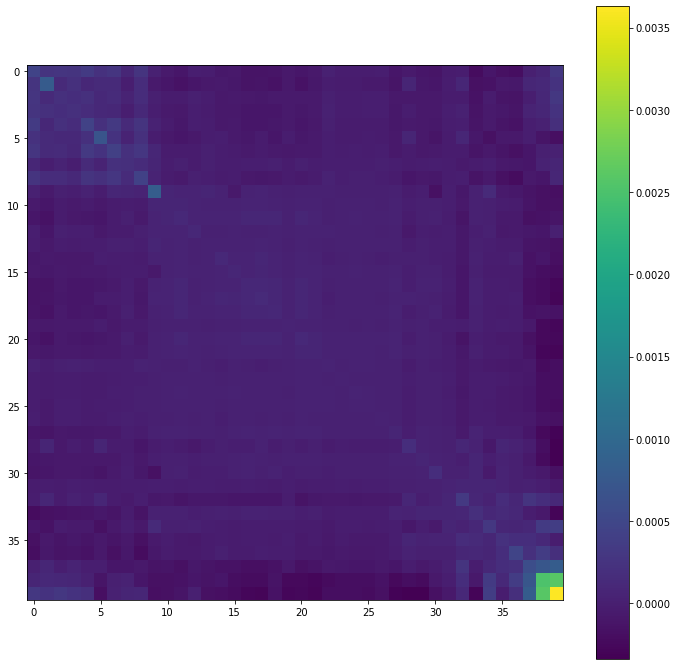

In [12]:
pl.figure(figsize=(12,12))
pl.imshow(cov_matrix)
pl.colorbar()


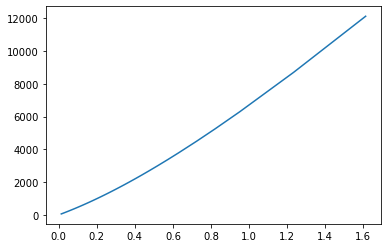

In [3]:
d_L = luminosity_dist(red_shift_data,.286,.714,69.6,1E2,"s")

pl.plot(red_shift_data,d_L)

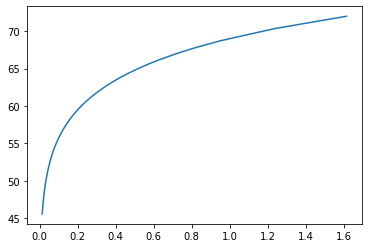

In [4]:
mu_model = distance_modulus(red_shift_data,.286,.714,69.6,1E2)
pl.plot(red_shift_data,mu_model)

In [7]:
pars_label = [r'$\Omega_m$',r'$\Omega_{\Lambda}$',r'$H_0$']
Omegas = [0.3,0.7,70]
cov_gen = np.diag([0.1,0.1,5])
chain = run_MCMC(red_shift_data,apparent_magnitude_data,cov_matrix,Omegas,cov_gen,nsteps=50000)


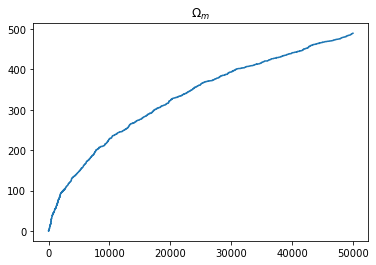

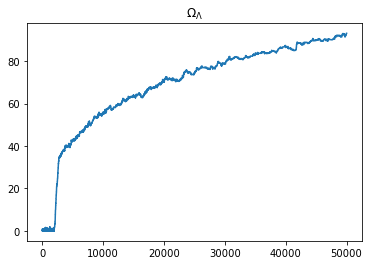

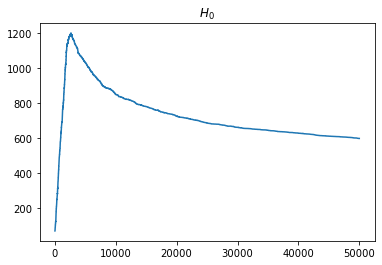

In [8]:
for i in range(chain.shape[1]):
    pl.figure()
    
    c = chain[:,i]
    n = range(chain.shape[0])
    pl.title(pars_label[i])
    pl.plot(n,c)
    

In [8]:
luminosity_dist(z,omega_m,omega_a=,H_0=70)

1000

In [8]:
luminosity_dist(.01,.286,.714,69.6,1E2)


43.41082897074749